# Supervised learning- MLP

For this labo, we use the hotel_bookings dataset from the machine learning module. The goal is to predict if a booking will be cancelled or not. Do you expect deep learning to perform better than the machine learning algorithms here?

The format is the same as in machine learning. Some of the code is already given. If you see any '...', then you need to add the right code yourself. Towards the end of the labo, less and less of the code will be given in advance and you will have to completely write the code yourself.

# 0. Loading packages and dataset

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

plt.style.use('seaborn-darkgrid')

df = pd.read_csv('hotel_bookings_cleaned.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     10000 non-null  int64  
 1   lead_time                       10000 non-null  float64
 2   arrival_date_year               10000 non-null  int64  
 3   arrival_date_week_number        10000 non-null  int64  
 4   arrival_date_day_of_month       10000 non-null  int64  
 5   stays_in_weekend_nights         10000 non-null  float64
 6   stays_in_week_nights            10000 non-null  float64
 7   adults                          10000 non-null  int64  
 8   children                        10000 non-null  float64
 9   babies                          10000 non-null  float64
 10  is_repeated_guest               10000 non-null  int64  
 11  previous_cancellations          10000 non-null  float64
 12  previous_bookings_not_canceled  1

In [3]:
df['is_repeated_guest'] = df['is_repeated_guest'].astype('category')


In [4]:
df.iloc[:,10:20].describe()

,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,length_stays,total_previous_bookings
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.047441,0.034799,0.112051,0.176386,4.555015,0.017439,0.335947,1.295266,0.076938
std,0.191811,0.268270,0.302555,0.841929,0.665205,0.109203,0.437047,0.400273,0.320325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,4.394449,0.000000,0.000000,1.098612,0.000000
50%,0.000000,0.000000,0.000000,0.000000,4.615121,0.000000,0.000000,1.386294,0.000000
75%,0.000000,0.000000,0.000000,0.000000,4.844187,0.000000,0.693147,1.609438,0.000000
max,3.091042,4.276666,2.833213,5.971262,5.930918,1.386294,1.791759,3.526361,4.356709


## 0. Preparing the data
The preparation of the data is very similar in deep learning as it is in machine learning.
1. Split the data in the features (X) and the outcome (y). 
2. Then perform the train-test split, with 20% of the samples in the test set
3. Standardise the numeric features (feature 0 to 19, but not the categorical feature 'is_repeated_guests)
4. In deep learning, the outcome in classification problems has to be one-hot-encoded. Do this.

1. Split the data in the features (X) and the outcome (y).  

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import Random

df_shuffle = df.sample(frac=1, random_state=40)

X = df_shuffle.drop(['is_canceled'],1)
y = df_shuffle['is_canceled']

2. Then perform the train-test split, with 20% of the samples in the test set


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


3. Standardise the numeric features

In [7]:
num = X_train.iloc[:,0:19].select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()
X_train_stand[num] = scaler.fit_transform(X_train[num])
X_test_stand[num] = scaler.transform(X_test[num])

In [8]:
X_train_stand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 9176 to 7056
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   lead_time                       8000 non-null   float64 
 1   arrival_date_year               8000 non-null   float64 
 2   arrival_date_week_number        8000 non-null   float64 
 3   arrival_date_day_of_month       8000 non-null   float64 
 4   stays_in_weekend_nights         8000 non-null   float64 
 5   stays_in_week_nights            8000 non-null   float64 
 6   adults                          8000 non-null   float64 
 7   children                        8000 non-null   float64 
 8   babies                          8000 non-null   float64 
 9   is_repeated_guest               8000 non-null   category
 10  previous_cancellations          8000 non-null   float64 
 11  previous_bookings_not_canceled  8000 non-null   float64 
 12  booking_changes  

4. One-hot encoding the outcome

In [9]:
y_class = y_train.copy()
y_test_class = y_test.copy()

In [10]:
from keras.utils.np_utils import to_categorical
y_train_class = to_categorical(y_class)

# 1. Classification

1. We start with setting up the architecture of the model. We construct a model with 3 hidden layers, each with 100 nodes.
    + All nodes should be Dense (meaning all nodes are connected with each other)
    + Define the activation function for all layers 
       - which activation function do you use in the hidden layers?
           - relu
       - And in the output layer?
           - sigmoid
    + Define the number of nodes for all layers
    + The first hidden layer also has to be given the number of input nodes (so the number of features)
        - 51
    + How many nodes are there in the output layer?
        - 2
2. Compile the model
    + Use 'adam' as optimizer
    + Which loss will you use?
        - binary_crossentropy
    + Use the argument  metrics=['accuracy']
    
3. Fit the model
    + Split the training set in 80% training and 20% validation
    + Use 100 epochs
    + Use a batch size of 16
    + Make sure to store the results in an object
4. Evaluate
    + Plot the loss and validated loss over the different epochs.
    + Is your model overfitting, underfitting of neither?
        - overfitting
    + If the model is overfitting or underfitting, what can we do to fix this?
        - We can use early stopping to prevent this from happening
5. Refit the model, but now make sure the model does not start to overfit
    + Be careful that you use a new model. Pyhton still remembers the results of the previous model.
6. Re-evaluate
    + Plot the loss and validated loss over the different epochs. 
   

1. Architecture

In [11]:
# Define the number of input nodes
n_cols = X_train_stand.shape[1]

# Start the sequential model
model = Sequential()

# Construct the first hidden layer: 
    ## Dense nodes = alle nodes are connected to each other
    ## you have to give the number of input nodes
    ## the number of nodes in the layer
    ## the activation function
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))

# Construct the second hidden layer
model.add(Dense(100, activation='relu'))

# Construct the third hidden layer
model.add(Dense(100, activation='relu'))
# construct the output node
model.add(Dense(2, activation='sigmoid'))



2. Compile the model

In [12]:
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])

3. Fit the model

In [13]:
# stand and class
fit = model.fit(X_train_stand, y_train_class ,validation_split=0.2, epochs= 100, batch_size=16)

Epoch 1/100
400/400 [==============================] - 1s 1ms/step - loss: 0.4537 - accuracy: 0.7837 - val_loss: 0.4282 - val_accuracy: 0.7962
Epoch 2/100
400/400 [==============================] - 0s 757us/step - loss: 0.4034 - accuracy: 0.8081 - val_loss: 0.4031 - val_accuracy: 0.8125
Epoch 3/100
400/400 [==============================] - 0s 757us/step - loss: 0.3860 - accuracy: 0.8180 - val_loss: 0.3951 - val_accuracy: 0.8150
Epoch 4/100
400/400 [==============================] - 0s 737us/step - loss: 0.3679 - accuracy: 0.8255 - val_loss: 0.4040 - val_accuracy: 0.8112
Epoch 5/100
400/400 [==============================] - 0s 750us/step - loss: 0.3542 - accuracy: 0.8353 - val_loss: 0.4007 - val_accuracy: 0.8206
Epoch 6/100
400/400 [==============================] - 0s 774us/step - loss: 0.3418 - accuracy: 0.8400 - val_loss: 0.4318 - val_accuracy: 0.7950
Epoch 7/100
400/400 [==============================] - 0s 752us/step - loss: 0.3283 - accuracy: 0.8461 - val_loss: 0.4116 - val_accu

400/400 [==============================] - 0s 757us/step - loss: 0.0568 - accuracy: 0.9787 - val_loss: 1.6150 - val_accuracy: 0.7856
Epoch 58/100
400/400 [==============================] - 0s 755us/step - loss: 0.0526 - accuracy: 0.9803 - val_loss: 1.6103 - val_accuracy: 0.7812
Epoch 59/100
400/400 [==============================] - 0s 762us/step - loss: 0.0695 - accuracy: 0.9770 - val_loss: 1.3874 - val_accuracy: 0.7850
Epoch 60/100
400/400 [==============================] - 0s 755us/step - loss: 0.0468 - accuracy: 0.9809 - val_loss: 1.5323 - val_accuracy: 0.7912
Epoch 61/100
400/400 [==============================] - 0s 747us/step - loss: 0.0409 - accuracy: 0.9847 - val_loss: 1.4894 - val_accuracy: 0.7962
Epoch 62/100
400/400 [==============================] - 0s 755us/step - loss: 0.0363 - accuracy: 0.9867 - val_loss: 1.5793 - val_accuracy: 0.8037
Epoch 63/100
400/400 [==============================] - 0s 757us/step - loss: 0.0362 - accuracy: 0.9847 - val_loss: 1.6153 - val_accuracy

4. Evaluate

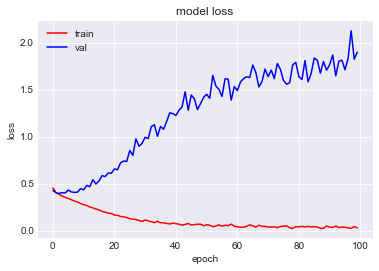

In [14]:
plt.plot(fit.history['loss'],'r')
plt.plot(fit.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

5. Refit

In [15]:
# Architecture
n_cols = X_train_stand.shape[1]
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(n_cols,)))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(2, activation="sigmoid"))

In [16]:
# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Fit
from keras.callbacks import EarlyStopping
early_stopping =  EarlyStopping(patience=2)

# stand and class
fit = model.fit(X_train_stand, y_train_class, validation_split=0.2, epochs=100, batch_size=16,
               callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 1s 1ms/step - loss: 0.4520 - accuracy: 0.7812 - val_loss: 0.4241 - val_accuracy: 0.7919
Epoch 2/100
400/400 [==============================] - 0s 770us/step - loss: 0.4032 - accuracy: 0.8081 - val_loss: 0.4127 - val_accuracy: 0.8100
Epoch 3/100
400/400 [==============================] - 0s 784us/step - loss: 0.3863 - accuracy: 0.8197 - val_loss: 0.4189 - val_accuracy: 0.8112
Epoch 4/100
400/400 [==============================] - 0s 757us/step - loss: 0.3686 - accuracy: 0.8295 - val_loss: 0.4094 - val_accuracy: 0.7956
Epoch 5/100
400/400 [==============================] - 0s 777us/step - loss: 0.3545 - accuracy: 0.8325 - val_loss: 0.3979 - val_accuracy: 0.8206
Epoch 6/100
400/400 [==============================] - 0s 774us/step - loss: 0.3392 - accuracy: 0.8438 - val_loss: 0.3968 - val_accuracy: 0.8169
Epoch 7/100
400/400 [==============================] - 0s 760us/step - loss: 0.3245 - accuracy: 0.8494 - val_loss: 0.4114 - val_accu

6. Evaluate



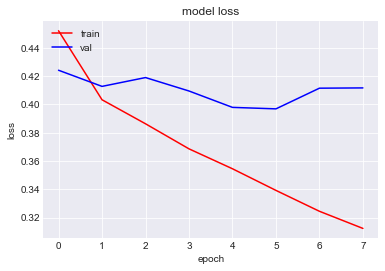

In [18]:
plt.plot(fit.history['loss'], 'r')
plt.plot(fit.history['val_loss'], 'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2. Regularisation
We have a pretty decent basic model. But, let's try to improve our model. We could use three strategies:
  1. Adding drop-out and batch normalization
  2. Babysitting method
  3. Random search (we wont do this here, if interested, see the demo)
    
## 2.1 Drop-out
Let's stick to the same model, but now add drop out 40% of the nodes in each hidden layer in each iteration.
1. Build, compile and fit the new model
2. Evaluate :Make a plot that compares the validated loss over the epochs in the new model and the old model
3. Add batch normalization to every layer and repeat the two previous steps 
    - Did the batch normalization improve the model?
        - The batch normalization doesn't seems to help

1. Build, compile and fit the new model

In [19]:
# Architecture
rate = 0.4
n_cols = X_train_stand.shape[1]
model2 = Sequential()
model2.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model2.add(Dropout(rate))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(rate))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(rate))
model2.add(Dense(2, activation='sigmoid'))


In [20]:
# compile
early_stopping =  EarlyStopping(patience=2)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# fit
fit2 = model2.fit(X_train_stand, y_train_class, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 1s 1ms/step - loss: 0.5419 - accuracy: 0.7245 - val_loss: 0.4272 - val_accuracy: 0.8044
Epoch 2/100
400/400 [==============================] - 0s 792us/step - loss: 0.4472 - accuracy: 0.7900 - val_loss: 0.4210 - val_accuracy: 0.8037
Epoch 3/100
400/400 [==============================] - 0s 802us/step - loss: 0.4329 - accuracy: 0.7992 - val_loss: 0.4138 - val_accuracy: 0.8069
Epoch 4/100
400/400 [==============================] - 0s 790us/step - loss: 0.4199 - accuracy: 0.8028 - val_loss: 0.4101 - val_accuracy: 0.8100
Epoch 5/100
400/400 [==============================] - 0s 777us/step - loss: 0.4150 - accuracy: 0.8003 - val_loss: 0.4086 - val_accuracy: 0.8056
Epoch 6/100
400/400 [==============================] - 0s 790us/step - loss: 0.4107 - accuracy: 0.8044 - val_loss: 0.4045 - val_accuracy: 0.8144
Epoch 7/100
400/400 [==============================] - 0s 785us/step - loss: 0.4001 - accuracy: 0.8119 - val_loss: 0.4118 - val_accu

2. Evaluate using plot

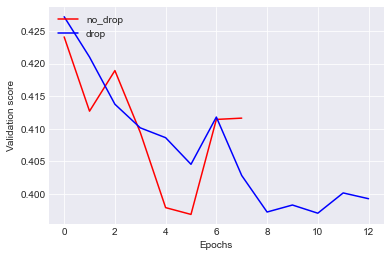

In [22]:
plt.plot(fit.history['val_loss'], 'r', fit2.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(['no_drop', 'drop'], loc='upper left')

plt.show()

3. Batch normalization

In [23]:
model3 = Sequential()
model3.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model3.add(Dropout(rate))
model3.add(BatchNormalization())
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(rate))
model3.add(BatchNormalization())
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(rate))
model3.add(BatchNormalization())
model3.add(Dense(2, activation='sigmoid'))

early_stopping =  EarlyStopping(patience=2)
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

fit3 = model3.fit(X_train_stand, y_train_class, validation_split= 0.2, epochs=100, batch_size=16, callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 1s 1ms/step - loss: 0.6313 - accuracy: 0.6878 - val_loss: 0.4408 - val_accuracy: 0.7944
Epoch 2/100
400/400 [==============================] - 0s 1ms/step - loss: 0.5271 - accuracy: 0.7519 - val_loss: 0.4349 - val_accuracy: 0.7937
Epoch 3/100
400/400 [==============================] - 0s 1ms/step - loss: 0.4922 - accuracy: 0.7677 - val_loss: 0.4299 - val_accuracy: 0.8000
Epoch 4/100
400/400 [==============================] - 0s 1ms/step - loss: 0.4749 - accuracy: 0.7763 - val_loss: 0.4291 - val_accuracy: 0.8019
Epoch 5/100
400/400 [==============================] - 0s 1ms/step - loss: 0.4692 - accuracy: 0.7763 - val_loss: 0.4196 - val_accuracy: 0.8087
Epoch 6/100
400/400 [==============================] - 0s 1ms/step - loss: 0.4679 - accuracy: 0.7825 - val_loss: 0.4300 - val_accuracy: 0.8062
Epoch 7/100
400/400 [==============================] - 0s 1ms/step - loss: 0.4697 - accuracy: 0.7805 - val_loss: 0.4235 - val_accuracy: 0.8081

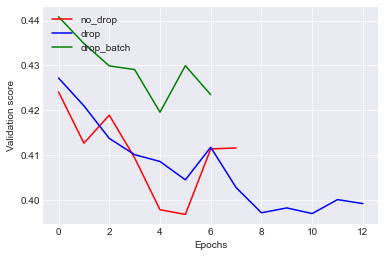

In [24]:
plt.plot(fit.history['val_loss'], 'r', 
         fit2.history['val_loss'], 'b',
         fit3.history['val_loss'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(['no_drop', 'drop','drop_batch'], loc='upper left')

plt.show()

## 2.2 Babysitting

Let's start over, but now use the babysitting method
1. Begin with a model with 1 hidden layer with 5 nodes and use a drop-out rate of 0.2. (model a)
2. Increase the number of nodes to 10 (model b)
    + compare the results of model a and b (using  plot of the validated loss over the epochs)
3. If model b is better than model a, increase the complexity of the model by adding a second layer (model c). If it is worse, stop here.
4. If model c is better than model b, increase the complexity by increasing the number of nodes to 25. If the model is worse, decrease the complexity by decreasing the number of nodes to 7.
5. Choose the best model so far to evaluate teh algoritm on the test dataset.

1. Model a

In [25]:
 # Architecture
modela = Sequential()
modela.add(Dense(5, activation='relu', input_shape=(n_cols,)))
modela.add(Dropout(0.2))
modela.add(Dense(2, activation='sigmoid'))

# Compile
modela.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit
fita = modela.fit(X_train_stand, y_train_class, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 1s 840us/step - loss: 0.6468 - accuracy: 0.6237 - val_loss: 0.5876 - val_accuracy: 0.7362
Epoch 2/100
400/400 [==============================] - 0s 622us/step - loss: 0.5835 - accuracy: 0.7525 - val_loss: 0.5417 - val_accuracy: 0.7875
Epoch 3/100
400/400 [==============================] - 0s 607us/step - loss: 0.5484 - accuracy: 0.7734 - val_loss: 0.5166 - val_accuracy: 0.8037
Epoch 4/100
400/400 [==============================] - 0s 619us/step - loss: 0.5142 - accuracy: 0.7839 - val_loss: 0.4650 - val_accuracy: 0.7975
Epoch 5/100
400/400 [==============================] - 0s 606us/step - loss: 0.4765 - accuracy: 0.7864 - val_loss: 0.4408 - val_accuracy: 0.7956
Epoch 6/100
400/400 [==============================] - 0s 609us/step - loss: 0.4548 - accuracy: 0.7953 - val_loss: 0.4297 - val_accuracy: 0.8044
Epoch 7/100
400/400 [==============================] - 0s 614us/step - loss: 0.4514 - accuracy: 0.7950 - val_loss: 0.4266 - val_ac

2. Model b

Now we increase the number of nodes to 10. 

In [26]:
 # Architecture
modelb = Sequential()
modelb.add(Dense(10, activation='relu', input_shape=(n_cols,)))
modelb.add(Dropout(0.2))
modelb.add(Dense(2, activation='sigmoid'))


# Compile
modelb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit
fitb = modelb.fit(X_train_stand, y_train_class, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 1s 842us/step - loss: 0.6072 - accuracy: 0.6800 - val_loss: 0.4921 - val_accuracy: 0.7925
Epoch 2/100
400/400 [==============================] - 0s 609us/step - loss: 0.4826 - accuracy: 0.7739 - val_loss: 0.4453 - val_accuracy: 0.7919
Epoch 3/100
400/400 [==============================] - 0s 601us/step - loss: 0.4512 - accuracy: 0.7870 - val_loss: 0.4297 - val_accuracy: 0.7937
Epoch 4/100
400/400 [==============================] - 0s 644us/step - loss: 0.4381 - accuracy: 0.7934 - val_loss: 0.4215 - val_accuracy: 0.8050
Epoch 5/100
400/400 [==============================] - 0s 609us/step - loss: 0.4314 - accuracy: 0.7972 - val_loss: 0.4182 - val_accuracy: 0.8025
Epoch 6/100
400/400 [==============================] - 0s 619us/step - loss: 0.4276 - accuracy: 0.8003 - val_loss: 0.4163 - val_accuracy: 0.8094
Epoch 7/100
400/400 [==============================] - 0s 637us/step - loss: 0.4231 - accuracy: 0.8034 - val_loss: 0.4137 - val_ac

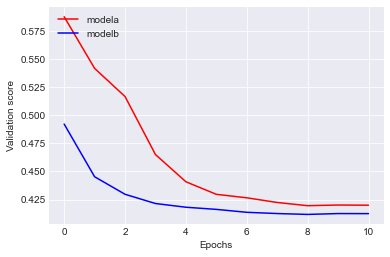

In [27]:
plt.plot(fita.history['val_loss'], 'r', fitb.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(['modela', 'modelb'], loc='upper left')

plt.show()

Now, let's add another hidden layer with 10 nodes.

3. Model c

In [28]:
 # Architecture
modelc = Sequential()
modelc.add(Dense(10, activation='relu', input_shape=(n_cols,)))
modelc.add(Dropout(0.2))
modelc.add(Dense(10, activation='relu'))
modelc.add(Dropout(0.2))
modelc.add(Dense(2, activation='sigmoid'))


# Compile
modelc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit
fitc = modelc.fit(X_train_stand, y_train_class, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 1s 867us/step - loss: 0.6185 - accuracy: 0.6542 - val_loss: 0.5251 - val_accuracy: 0.7906
Epoch 2/100
400/400 [==============================] - 0s 647us/step - loss: 0.5097 - accuracy: 0.7638 - val_loss: 0.4404 - val_accuracy: 0.8019
Epoch 3/100
400/400 [==============================] - 0s 639us/step - loss: 0.4657 - accuracy: 0.7880 - val_loss: 0.4229 - val_accuracy: 0.8019
Epoch 4/100
400/400 [==============================] - 0s 637us/step - loss: 0.4495 - accuracy: 0.7950 - val_loss: 0.4166 - val_accuracy: 0.8081
Epoch 5/100
400/400 [==============================] - 0s 642us/step - loss: 0.4369 - accuracy: 0.8048 - val_loss: 0.4135 - val_accuracy: 0.8056
Epoch 6/100
400/400 [==============================] - 0s 667us/step - loss: 0.4288 - accuracy: 0.8022 - val_loss: 0.4093 - val_accuracy: 0.8119
Epoch 7/100
400/400 [==============================] - 0s 642us/step - loss: 0.4267 - accuracy: 0.8053 - val_loss: 0.4110 - val_ac

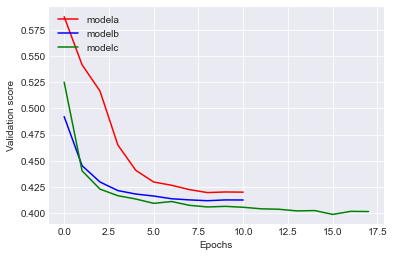

In [29]:
# plot
plt.plot(fita.history['val_loss'], 'r',
         fitb.history['val_loss'], 'b',
         fitc.history['val_loss'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(['modela', 'modelb', 'modelc'], loc='upper left')

plt.show()

 Lets decrease the number of nodes in the  hidden layers to 7.

4. Model d

If model c is better than model b, increase the complexity by increasing the number of nodes to 25. If the model is worse, decrease the complexity by decreasing the number of nodes to 7.

In [30]:
 # Architecture
modeld = Sequential()
modeld.add(Dense(25, activation='relu', input_shape=(n_cols,)))
modeld.add(Dropout(0.2))
modeld.add(Dense(25, activation='relu'))
modeld.add(Dropout(0.2))
modeld.add(Dense(2, activation='sigmoid'))


# Compile
modeld.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit
fitd = modeld.fit(X_train_stand, y_train_class, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 1s 875us/step - loss: 0.5564 - accuracy: 0.7108 - val_loss: 0.4424 - val_accuracy: 0.7925
Epoch 2/100
400/400 [==============================] - 0s 652us/step - loss: 0.4539 - accuracy: 0.7872 - val_loss: 0.4263 - val_accuracy: 0.8056
Epoch 3/100
400/400 [==============================] - 0s 657us/step - loss: 0.4326 - accuracy: 0.7970 - val_loss: 0.4178 - val_accuracy: 0.8062
Epoch 4/100
400/400 [==============================] - 0s 662us/step - loss: 0.4262 - accuracy: 0.8002 - val_loss: 0.4148 - val_accuracy: 0.8050
Epoch 5/100
400/400 [==============================] - 0s 659us/step - loss: 0.4123 - accuracy: 0.8083 - val_loss: 0.4124 - val_accuracy: 0.8031
Epoch 6/100
400/400 [==============================] - 0s 652us/step - loss: 0.4096 - accuracy: 0.8108 - val_loss: 0.4094 - val_accuracy: 0.8119
Epoch 7/100
400/400 [==============================] - 0s 654us/step - loss: 0.4063 - accuracy: 0.8081 - val_loss: 0.4058 - val_ac

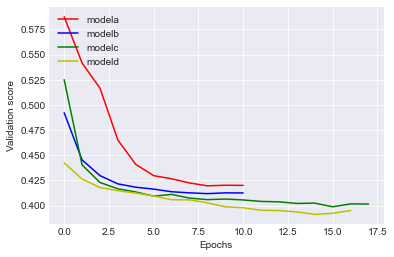

In [31]:
# plot

plt.plot(fita.history['val_loss'], 'r',
         fitb.history['val_loss'], 'b',
         fitc.history['val_loss'], 'g',
         fitd.history['val_loss'], 'y')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(['modela', 'modelb', 'modelc', 'modeld'], loc='upper left')

plt.show()

We choose the best model to try on our test dataset.

5. Evaluating on test set

In [32]:
predictions_test = modela.predict_classes(X_test_stand)
print(classification_report(y_test_class, predictions_test))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1181
           1       0.83      0.66      0.74       819

    accuracy                           0.81      2000
   macro avg       0.81      0.78      0.79      2000
weighted avg       0.81      0.81      0.80      2000



C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [33]:
predictions_test = modelb.predict_classes(X_test_stand)
print(classification_report(y_test_class, predictions_test))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1181
           1       0.82      0.67      0.74       819

    accuracy                           0.81      2000
   macro avg       0.81      0.78      0.79      2000
weighted avg       0.81      0.81      0.80      2000



C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [34]:
predictions_test = modelc.predict_classes(X_test_stand)
print(classification_report(y_test_class, predictions_test))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1181
           1       0.86      0.64      0.74       819

    accuracy                           0.81      2000
   macro avg       0.83      0.79      0.80      2000
weighted avg       0.82      0.81      0.81      2000



C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [35]:
predictions_test = modeld.predict_classes(X_test_stand)
print(classification_report(y_test_class, predictions_test))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86      1181
           1       0.83      0.70      0.76       819

    accuracy                           0.82      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.82      0.82      0.82      2000



C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


We clearly can see that model D has the highest accuracy rate of 82%.

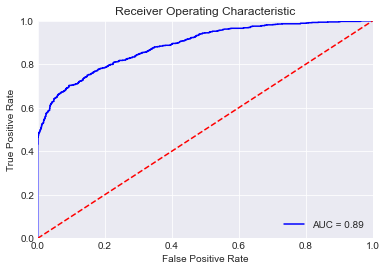

In [39]:
# print the ROC-curve
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = modeld.predict(X_test_stand)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_class, preds)
roc_auc = metrics.auc(fpr, tpr)
 
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We will end this labo here. If you would look back at the results that we got on this dataset in the machine learning course, you would notice we didn't really improve our results. The power of deep learning isn't in this kind of tasks, but rather on more specialized tasks, such as image recognition, text processing,... We will learn a lot more about this in the next few class.

In [38]:
For those interested, the code to do a random search is below, but this is not part of the curriculum.

SyntaxError: invalid syntax (<ipython-input-38-2609d8c798c0>, line 1)

## 2.2 Random search
1. Define the model
You start by creating an overal model. For all parameters that you want to use in the random search, you give a default value. 
2. Use KerasClassifier to store the model. 
Arguments that usually go into the fit are given here.  
3. Define the parameter grid.
Do a very limited search. Keep all parameters fixed as before, only let the drop-out range from 0 to 0.9. Try 10 values.

1. Define the mode

In [ ]:
def get_model(optimizer='adam',activation_hidden = 'relu',activation_output = 'sigmoid',
              dropout_rate = 0.0,neurons = 100):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation_hidden))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons ,activation=activation_hidden))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation_hidden))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation=activation_output))

    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy']) 
    return model

2. Store model using Keras Classifier

In [ ]:
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=get_model, batch_size=8, epochs =10)

3. Define the parameter grid.


In [ ]:

activation_hidden =  ['relu'] 
activation_output =  ['sigmoid'] 
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
neurons = [100]
optimizer = ['Adam']
epochs = [50] 
batch_size = [16] 
param_grid = {'activation_hidden': activation_hidden,
              'activation_output': activation_output,
              'dropout_rate' : dropout_rate,
              'neurons': neurons,
              'optimizer': optimizer,
              'epochs': epochs,
              'batch_size':batch_size}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
grid = RandomizedSearchCV(estimator=model, param_distributions = param_grid, n_iter= 20, cv=3, 
                          verbose=2, random_state=42, n_jobs=-1)
grid_result = grid.fit(X_train_stand, y_train_class) 


In [ ]:
grid_result.best_params_

In [ ]:
predictions_test = grid_result.predict(X_test_stand)
print(classification_report(y_test_class, predictions_test))